Vasanth Banumurthy (CS 7470: Mobile & Ubiquitous Computing)

<span style="color:blue; font-size:2em;"> **SETUP** </span>

[You can remove this text from the final report. This is just to help you set up correctly.]

Some tips for using jupyter notebook:
1. Check whether you are in code or markdown mode in each cell of the report. You can switch between them by clicking on the dropdown.
2. To plot figures, use plot_data() defined below. If you need to insert an image using markdown, you can use this code: `![title](image_folder/image_name.png)`
3. You should not have to edit the python files in the github repository for any of the tasks below. We have shared them just in case though.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd "/content/drive/My Drive/Colab Notebooks/MUC_Sensor_Project"

/content/drive/My Drive/Colab Notebooks/MUC_Sensor_Project


In [8]:
# this function creates all in-line plots. DO NOT DELETE.
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt


def plot_data(data, filename):
    # adjust rcParams as needed to make your graph readable
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.title(f'X,Y,Z Plot ({filename})')
    plt.plot([row[0] for row in data],[row[1] for row in data], label="x")
    plt.plot([row[0] for row in data],[row[2] for row in data], label="y")
    plt.plot([row[0] for row in data],[row[3] for row in data], label="z")
    plt.legend(loc='upper right')
    plt.show()

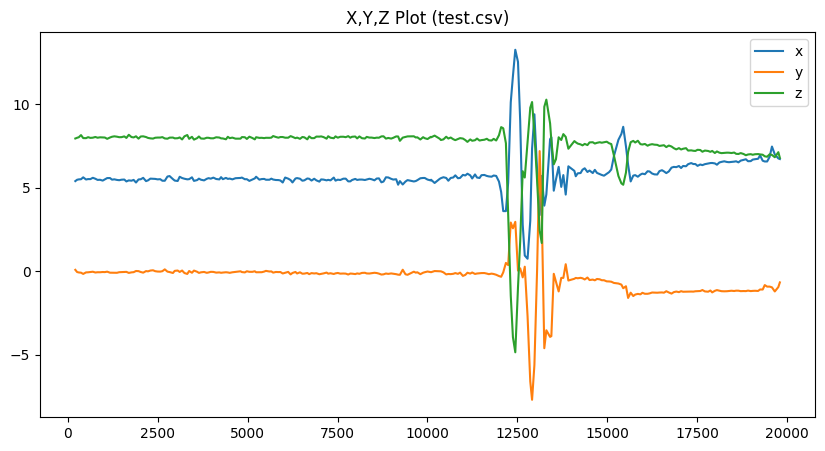

In [9]:
# this file is test.py
import parser_data
# numpy imported to check if the student has numpy
import numpy

filename = "test.csv"
data_test = parser_data.get_data(filename)
plot_data(data_test, filename)

<span style="color:blue; font-size:2em;"> **TASK 1** </span>

### INSTRUCTIONS

**In your report** <br>

Calculate: <br>
**a. [3 points]** Open walking_steps.csv collected and check relative_time column. What is the sampling rate for the accelerometer data?

Reflect: <br>
**b. [3 points]** Is the sampling rate stable for the file walking_steps.csv? What is the variation? If it is not stable, explain what could be affecting the stability of the rate? (Hint: https://pure.au.dk/ws/files/93103132/sen099_stisenAT3.pdf, no need to thoroughly read the whole paper, this is just to lead you to think in the right direction. Looking at the first two pages should be sufficient) <br>
**c. [3 points]** How does your understanding from part (a) affect your data processing pipeline? <br>
**d. [3 points]** How can we make the data easier to work with (hint: [re-sampling the data](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.resample.html) )? Choose one method of your choice and briefly explain how the math works. <br>
**e. [3 points]** Do you think the current  sampling rate is a good basis for capturing human movements like walking?  Explain your reasons for or against your case.  <br>

In [9]:
import pandas as pd
import numpy as np
from scipy import signal
import parser_data
import matplotlib.pyplot as plt
from google.colab import files


# Define a function to resample the data
def resample_csv(filename, target_hz=50):
    # Use parser_data.get_data() to load the data
    data = parser_data.get_data(filename)

    # Convert data to pandas DataFrame - adjust columns based on what parser_data provides
    df = pd.DataFrame(data, columns=['Time (s)', 'Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)'])

    # Display information about the original data
    print(f"Original data shape: {df.shape}")
    original_duration = df['Time (s)'].iloc[-1] - df['Time (s)'].iloc[0]
    original_samples = len(df)
    original_hz = original_samples / original_duration
    print(f"Original sampling rate: {original_hz:.2f} Hz")

    # Calculate how many samples we need for the target frequency
    target_samples = int(original_samples * (target_hz / original_hz))
    print(f"Target samples: {target_samples} (for {target_hz} Hz)")

    # Extract time and acceleration columns
    time = df['Time (s)'].values
    acc_x = df['Acceleration x (m/s^2)'].values
    acc_y = df['Acceleration y (m/s^2)'].values
    acc_z = df['Acceleration z (m/s^2)'].values

    # Calculate absolute acceleration if needed
    acc_abs = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)

    # Resample each axis
    # https://edstem.org/us/courses/70746/discussion/5997140?comment=13899557
    new_time = np.linspace(time[0], time[-1], target_samples)
    resampled_x = signal.resample(acc_x, target_samples)
    resampled_y = signal.resample(acc_y, target_samples)
    resampled_z = signal.resample(acc_z, target_samples)
    resampled_abs = signal.resample(acc_abs, target_samples)

    # Create a new DataFrame with resampled data
    resampled_df = pd.DataFrame({
        'Time (s)': new_time,
        'Acceleration x (m/s^2)': resampled_x,
        'Acceleration y (m/s^2)': resampled_y,
        'Acceleration z (m/s^2)': resampled_z,
        'Absolute acceleration (m/s^2)': resampled_abs  # Adding the calculated absolute acceleration
    })

    # Save the resampled data
    output_filename = filename.replace('.csv', f'_resampled_{target_hz}hz.csv')
    resampled_df.to_csv(output_filename, index=False)
    print(f"Resampled data saved to {output_filename}")
    #files.download(output_filename)

    # Convert to format needed for plot_data function - only time and xyz are needed
    original_data = []
    for i in range(len(df)):
        original_data.append([
            df['Time (s)'].iloc[i],
            df['Acceleration x (m/s^2)'].iloc[i],
            df['Acceleration y (m/s^2)'].iloc[i],
            df['Acceleration z (m/s^2)'].iloc[i]
        ])

    resampled_data = []
    for i in range(len(resampled_df)):
        resampled_data.append([
            resampled_df['Time (s)'].iloc[i],
            resampled_df['Acceleration x (m/s^2)'].iloc[i],
            resampled_df['Acceleration y (m/s^2)'].iloc[i],
            resampled_df['Acceleration z (m/s^2)'].iloc[i]
        ])

    # Plot using the provided function
    print("Original data:")
    plot_data(original_data, f"Original {filename}")

    print("Resampled data:")
    plot_data(resampled_data, f"Resampled {target_hz}Hz {filename}")

    return resampled_df, output_filename

*  The data in walking_steps_1.csv was obtained with phone in my **front jeans pocket**
*  I've plotted both the **raw** and **resampled** data
*  The x-axis in your plot_data function represents time (in seconds), and the y-axis represents acceleration (in m/s²) for each of the three axes (x, y, and z).



Processing walking_steps_1.csv...
Original data shape: (33444, 4)
Original sampling rate: 422.12 Hz
Target samples: 3961 (for 50 Hz)
Resampled data saved to walking_steps_1_resampled_50hz.csv
Original data:


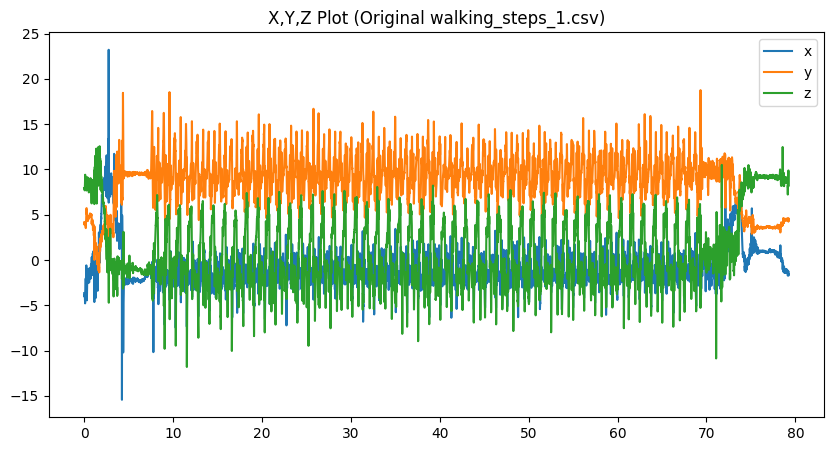

Resampled data:


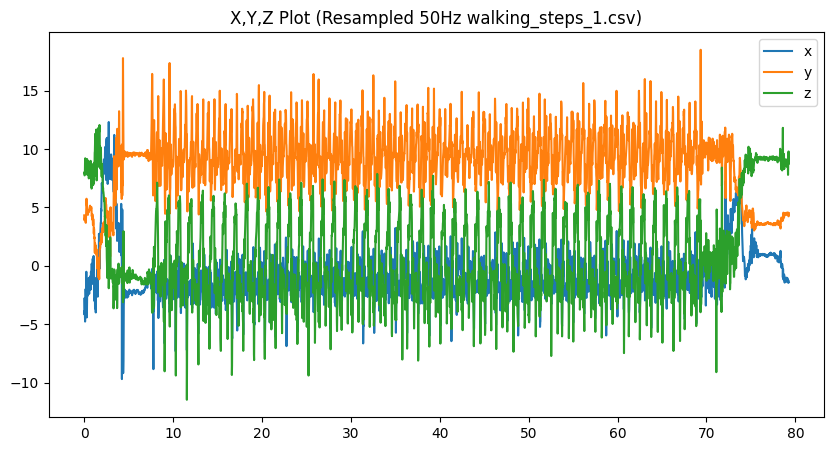

In [10]:
# Process both CSV files
target_frequency = 50  # Hz

print("\nProcessing walking_steps_1.csv...")
resampled_data1, file1 = resample_csv('walking_steps_1.csv', target_frequency)


* The data in walking_steps_2.csv was obtained with phone in my **hand**
* I've plotted both the **raw** and **resampled** data
* The x-axis in your plot_data function represents time (in seconds), and the y-axis represents acceleration (in m/s²) for each of the three axes (x, y, and z).






Processing walking_steps_2.csv...
Original data shape: (31040, 4)
Original sampling rate: 422.08 Hz
Target samples: 3676 (for 50 Hz)
Resampled data saved to walking_steps_2_resampled_50hz.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Original data:


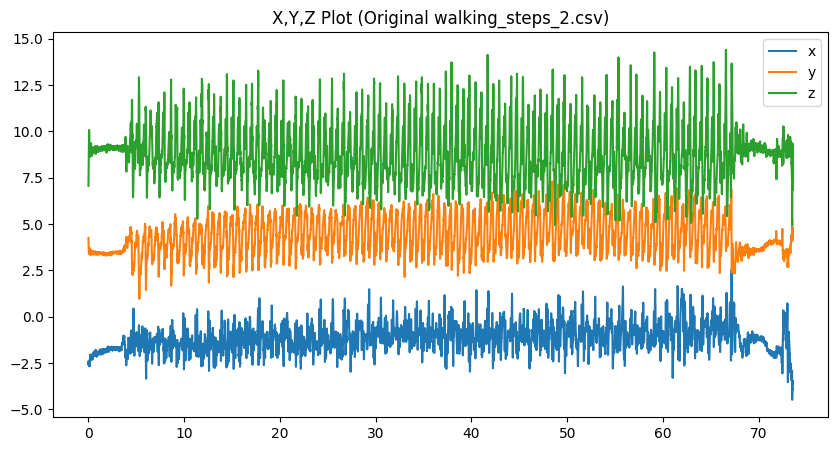

Resampled data:


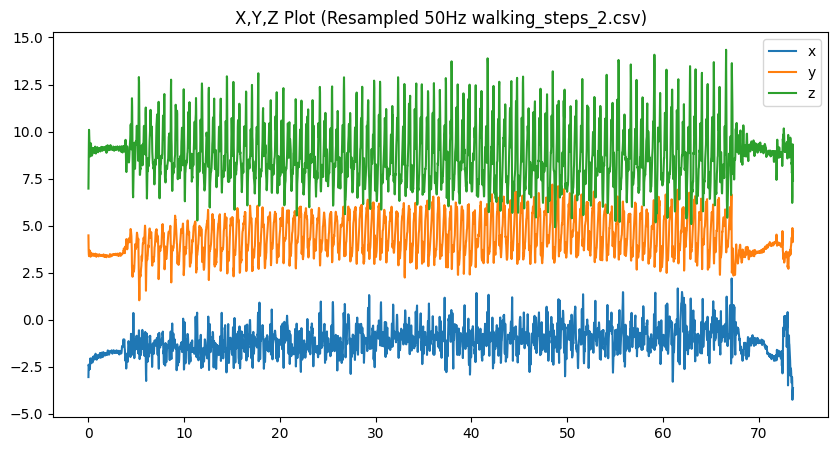

In [ ]:
# Process both CSV files
target_frequency = 50  # Hz

print("\nProcessing walking_steps_2.csv...")
resampled_data1, file1 = resample_csv('walking_steps_2.csv', target_frequency)

<span style="color:blue; font-size:2em;"> **TASK 2** </span>

### INSTRUCTIONS

**In your report** <br>
**a. [5 points]** Plot X, Y, Z  for walking_steps.csv and walking_steps_clean.csv <br>
**b. [5 points]** Plot X, Y, Z  for walking_steps2.csv and walking_steps_clean2.csv <br>
**c. [5 points]** Reflect on the movements in each axis, X, Y, Z of walking_steps_clean.csv. Give details as to how you collected the data and it resulted in movement in each axis.  <br>

**Code and Data files** <br>
In folder /data - Add walking_steps_clean.csv<br>
task2.py - Modify code clean_data below

**Note : Make sure you add/modify code below or your task 2 will not be graded.**  

Cleaning data for walking_steps_1.csv


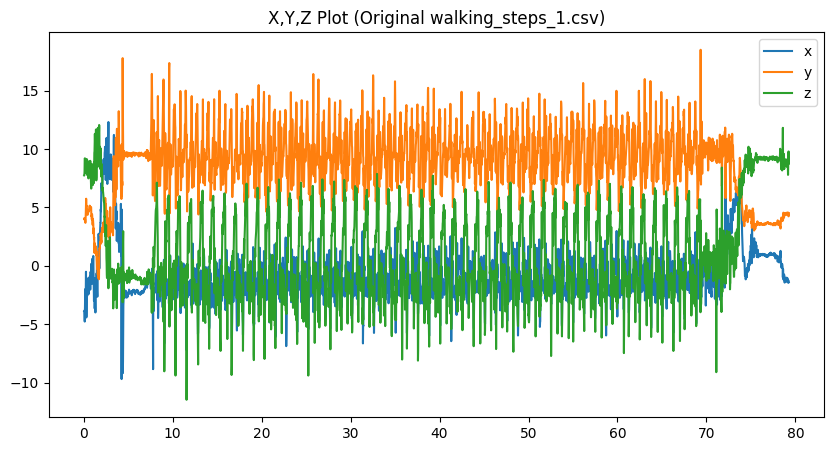

Using visual inspection: Removing data before 7.0s and after 71.0s
Original data length: 3959
Cleaned data length: 3199


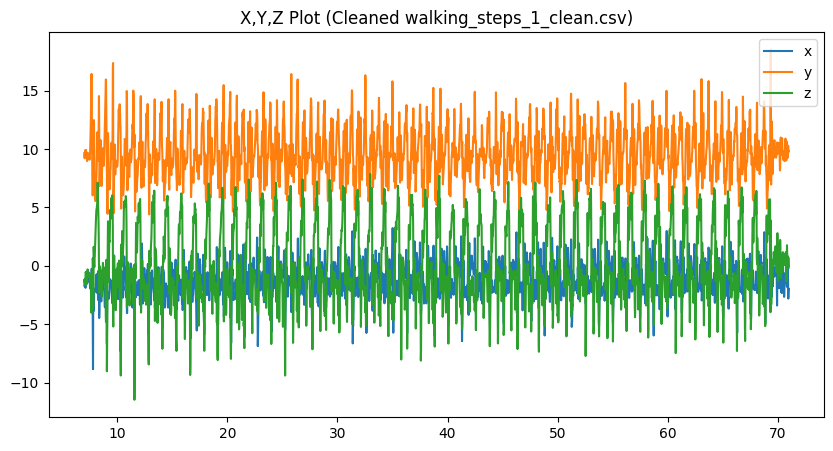

Cleaned data saved to data/walking_steps_1_clean.csv


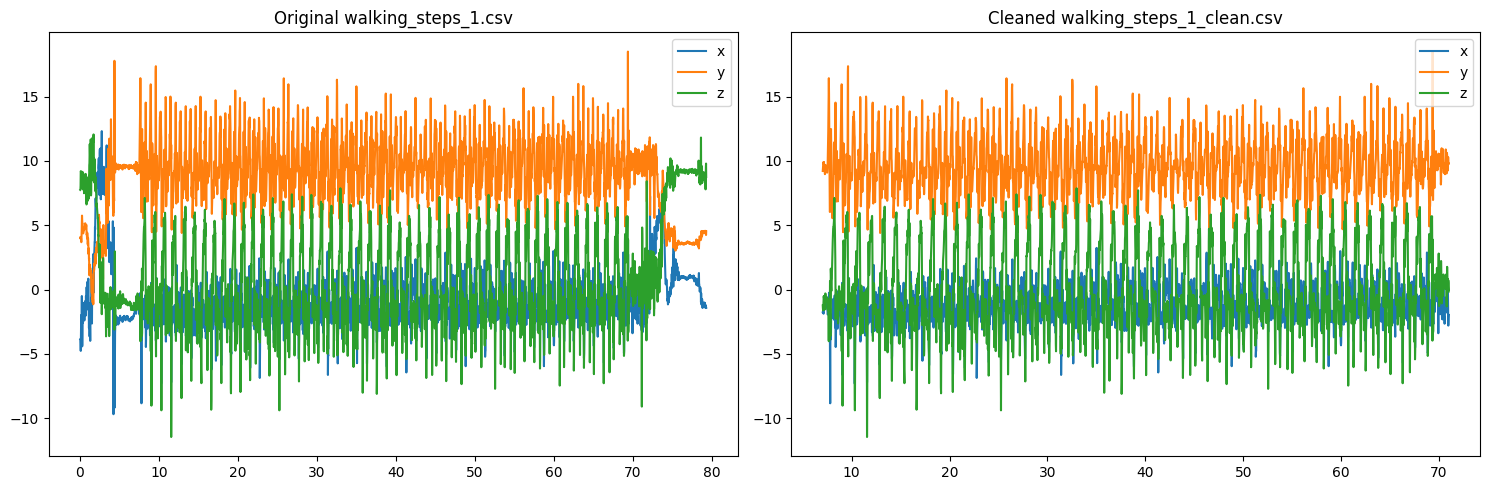

Cleaning data for walking_steps_2.csv


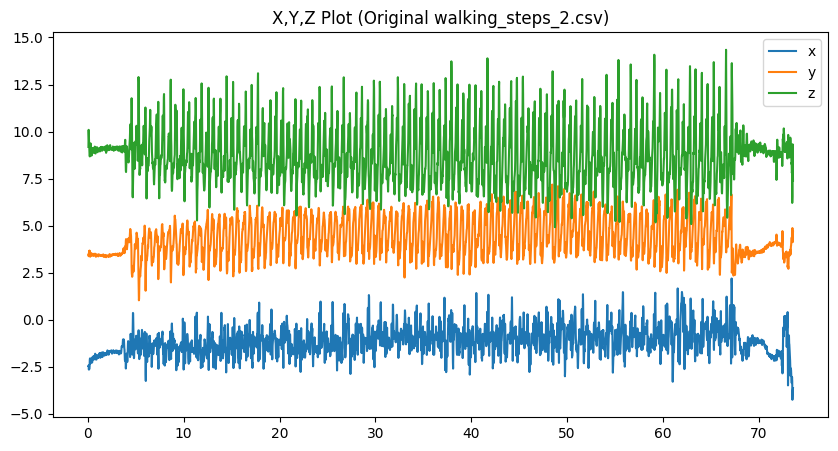

Using visual inspection: Removing data before 4.0s and after 68.0s
Original data length: 3674
Cleaned data length: 3198


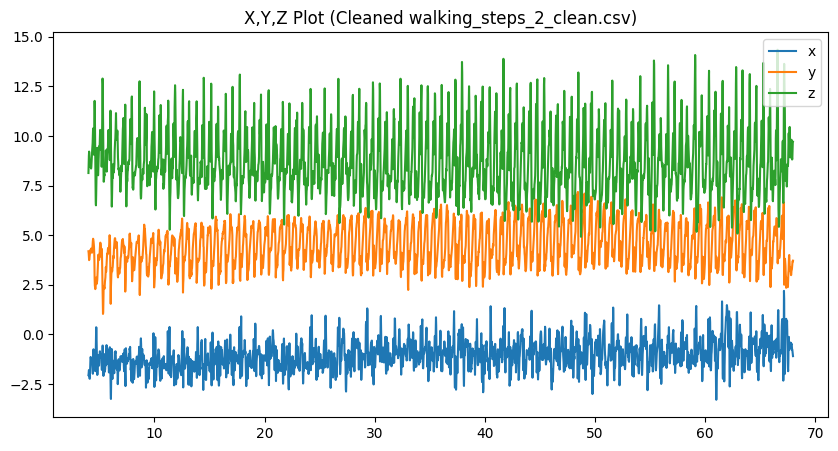

Cleaned data saved to data/walking_steps_2_clean.csv


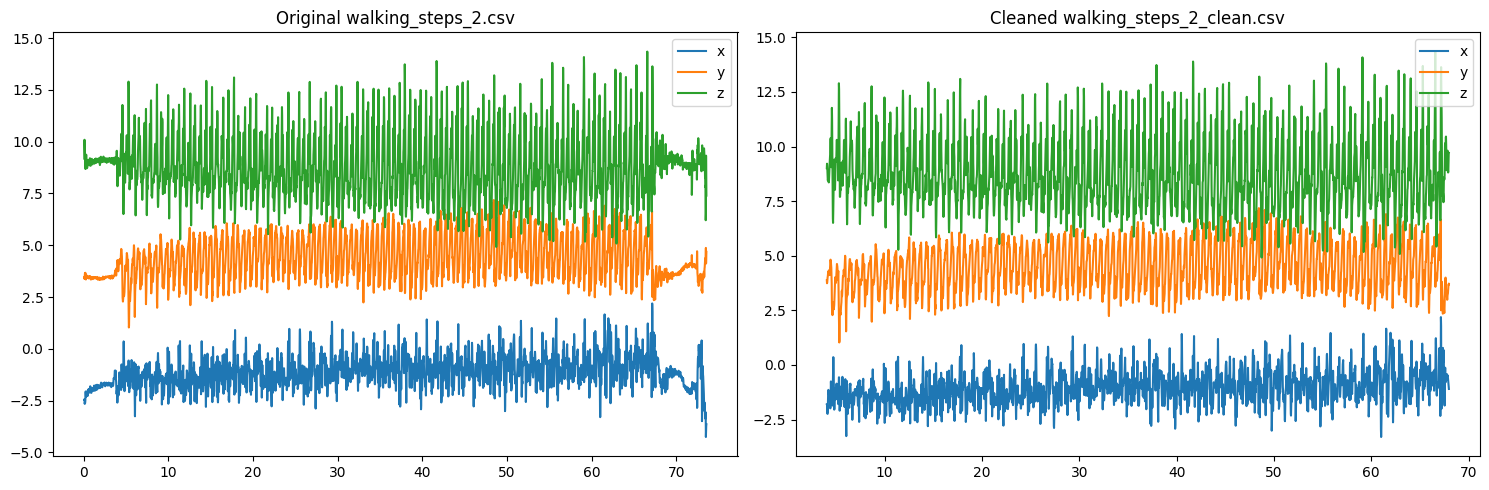

In [81]:
# this is task2.py
import parser_data
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files


def clean_data(data, num=None):
    print(f"Cleaning data for walking_steps_{num}.csv")

    # First, let's visualize the data
    plot_data(data, f"Original walking_steps_{num}.csv")

    # Based on visual inspection, set the start and end times for each file
    if num == 1:
        start_time = 7.0  # 7 seconds for walking_steps_1_resampled_50hz.csv
        end_time = 71.0   # 72 seconds for walking_steps_1_resampled_50hz.csv
    elif num == 2:
        start_time = 4.0  # 4 seconds for walking_steps_2_resampled_50hz.csv
        end_time = 68.0   # 68 seconds for walking_steps_2_resampled_50hz.csv

    print(f"Using visual inspection: Removing data before {start_time}s and after {end_time}s")

    # Filter data based on time window
    cleaned_data = []
    for row in data:
        if start_time <= row[0] <= end_time:
            cleaned_data.append(row)

    print(f"Original data length: {len(data)}")
    print(f"Cleaned data length: {len(cleaned_data)}")

    # Plot cleaned data for verification
    plot_data(cleaned_data, f"Cleaned walking_steps_{num}_clean.csv")

    # Create new file without garbage data and save it in data folder
    file_name_clean = f"data/walking_steps_{num}_clean.csv"
    with open(file_name_clean, "w") as f:
        f.write("time,X,Y,Z\n")
        for row in cleaned_data:
            f.write(f"{row[0]},{row[1]},{row[2]},{row[3]}\n")

    #files.download(file_name_clean)
    print(f"Cleaned data saved to {file_name_clean}")
    return cleaned_data



def main():
    # Get data
    for i in [1,2]:
        file_name = f"walking_steps_{i}_resampled_50hz.csv"
        data = parser_data.get_data(file_name) # data -- time,X,Y,Z
        cleaned_data = clean_data(data, i)

        # Load the cleaned data
        newdata = parser_data.get_data(f"walking_steps_{i}_clean.csv")

        # Plot original vs clean data side by side
        plt.figure(figsize=[15, 5])

        plt.subplot(1, 2, 1)
        plt.title(f'Original walking_steps_{i}.csv')
        plt.plot([row[0] for row in data], [row[1] for row in data], label="x")
        plt.plot([row[0] for row in data], [row[2] for row in data], label="y")
        plt.plot([row[0] for row in data], [row[3] for row in data], label="z")
        plt.legend(loc='upper right')

        plt.subplot(1, 2, 2)
        plt.title(f'Cleaned walking_steps_{i}_clean.csv')
        plt.plot([row[0] for row in newdata], [row[1] for row in newdata], label="x")
        plt.plot([row[0] for row in newdata], [row[2] for row in newdata], label="y")
        plt.plot([row[0] for row in newdata], [row[3] for row in newdata], label="z")
        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()


if __name__== "__main__":
    main()



<span style="color:blue; font-size:2em;"> **TASK 3** </span>

### INSTRUCTIONS

**In your report** <br>

**a. [6 points - 2 for each plot and 2 for reflection]**  <br>
Add the plot for magnitude for walking_steps_1_clean.csv and walking_steps_2_clean.csv.  <br>

1. Reflect how magnitude is different from X,Y,Z.
2. How are the magnitudes different in the 2 files? (hint: orientation)<br>

**b. [6 points - 2 for each plot and 2 for reflection]**  <br>
Add the plot for moving average for for walking_steps_1_clean.csv and walking_steps_2_clean.csv using the method you implemented.

1. How the moving average is different from magnitude.  <br>
2. On what factor(s) does moving average dependent?

**c. [8 points]** Describe your step counting process.  <br>

**d. [10 points - 5 each]** Run walking_steps_clean.csv through your algorithm. How many steps did you count? Plot your raw data with steps labeled on it  <br>
1. walking_steps_1_clean.csv through your algorithm.
2. walking_steps_2_clean.csv through your algorithm.


**e. [10 points]** Reflect on how your calculations are different from ground truth data (100 steps).   <br>

**Code**  <br>
1. **util.py** - modify to implement functions vector_magnitude, moving_average below <br>
2. **task3.py**  - implement count_steps below <br>

**Note : Make sure you add/modify code below or your task 3 will not be graded.**  

In [12]:
# this is util.py
from scipy.signal import butter, lfilter
import numpy


def vector_magnitude(data):
    """ function to calculate the magnitude of a vector
    Calculate the magnitude of the vector superposition of data (for
    example, acceleration) on x, y, and z axis

    Arguments: data: array of (x, y, z) tuples for a vector
    Returns: array of the magnitude of a vector

    """
    magnitudes = []

    for point in data:
        # Extract x, y, z components (assuming time is at index 0)
        x, y, z = point[1], point[2], point[3]

        # Calculate magnitude using the Euclidean norm formula: sqrt(x² + y² + z²)
        magnitude = numpy.sqrt(x**2 + y**2 + z**2)

        # Append the result to our list
        magnitudes.append(magnitude)

    return magnitudes


def moving_average(data, window_size):
    """ moving average filter

    Implement a simple moving average filter to use as a low pass filter

    Arguments: data: data be filtered, window_size: window_size chosen for the data

    Returns:The filtered data.

    TODO:Finish this function. Think about how you want to handle the size difference between your input array and output array.
        You can write it yourself or consider using numpy.convole for
        it:https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    # Create a window of ones with the specified size
    window = numpy.ones(window_size) / window_size

    # Use numpy.convolve with 'same' mode to keep output the same length as input
    filtered_data = numpy.convolve(data, window, mode='same')

    # Handle boundary effects at the beginning and end
    # For the beginning: use cumulative average for the first window_size points
    for i in range(min(window_size//2, len(data))):
        if i > 0:  # Skip the first point
            filtered_data[i] = numpy.mean(data[:i*2+1])

    # For the end: use cumulative average for the last window_size points
    for i in range(len(data) - window_size//2, len(data)):
        if i < len(data) - 1:  # Skip the last point
            filtered_data[i] = numpy.mean(data[-(len(data)-i)*2-1:])

    return filtered_data

* plot_magnitude(data, filename) uses vector_magnitude(data) and matplotlib



Magnitude plot for walking_steps_1_clean.csv:


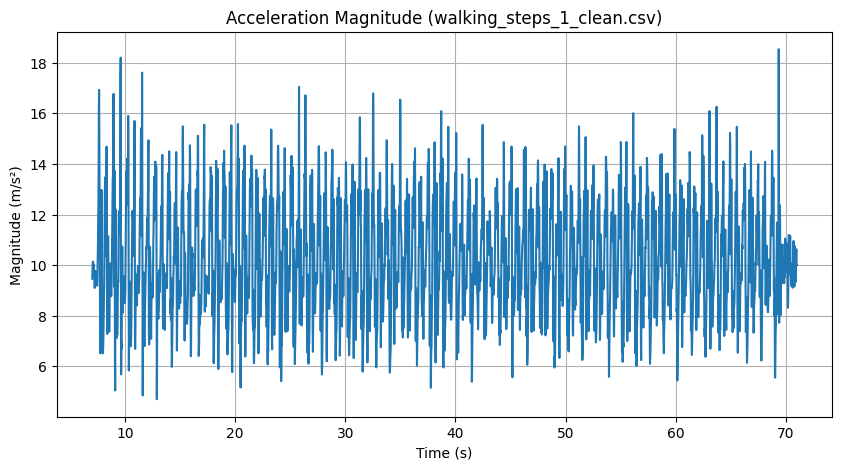

Magnitude plot for walking_steps_2_clean.csv:


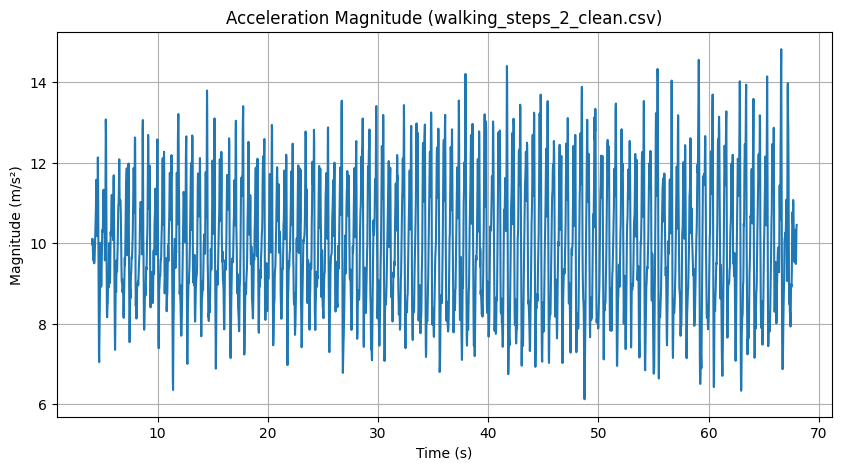

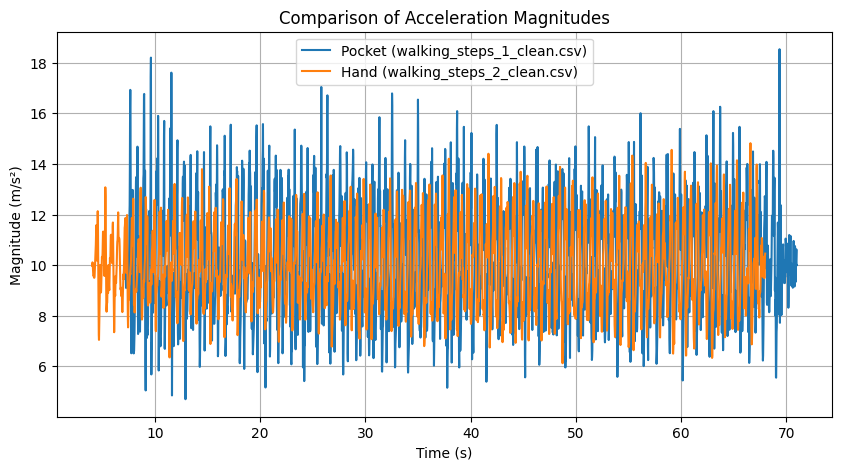

In [26]:
import matplotlib.pyplot as plt
import parser_data
import numpy as np

def plot_magnitude(data, filename):
    # Calculate magnitude
    magnitudes = vector_magnitude(data)

    # Extract time values (assuming they're at index 0 of each data point)
    times = [row[0] for row in data]

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(times, magnitudes)
    plt.title(f'Acceleration Magnitude ({filename})')
    plt.xlabel('Time (s)')
    plt.ylabel('Magnitude (m/s²)')
    plt.grid(True)
    plt.show()

    return times, magnitudes

# Load the cleaned data files
data1 = parser_data.get_data("walking_steps_1_clean.csv")
data2 = parser_data.get_data("walking_steps_2_clean.csv")

# Plot magnitudes for both files
print("Magnitude plot for walking_steps_1_clean.csv:")
times1, mag1 = plot_magnitude(data1, "walking_steps_1_clean.csv")

print("Magnitude plot for walking_steps_2_clean.csv:")
times2, mag2 = plot_magnitude(data2, "walking_steps_2_clean.csv")

plt.figure(figsize=(10, 5))
plt.plot(times1, mag1, label='Pocket (walking_steps_1_clean.csv)')
plt.plot(times2, mag2, label='Hand (walking_steps_2_clean.csv)')
plt.title('Comparison of Acceleration Magnitudes')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

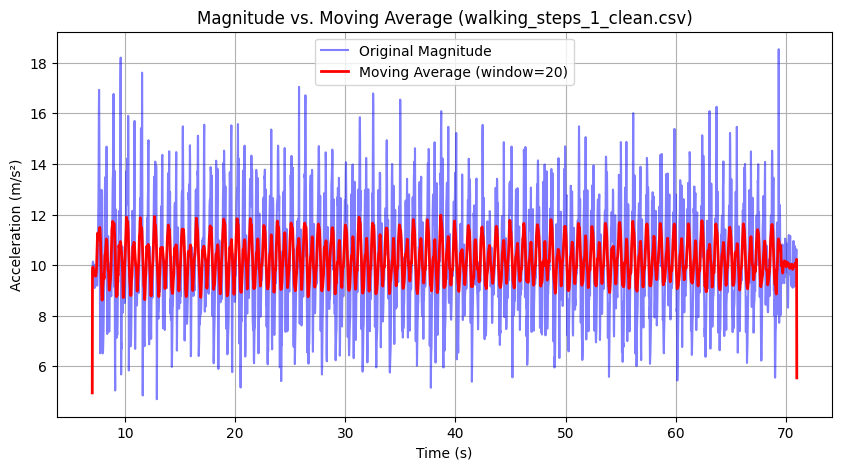

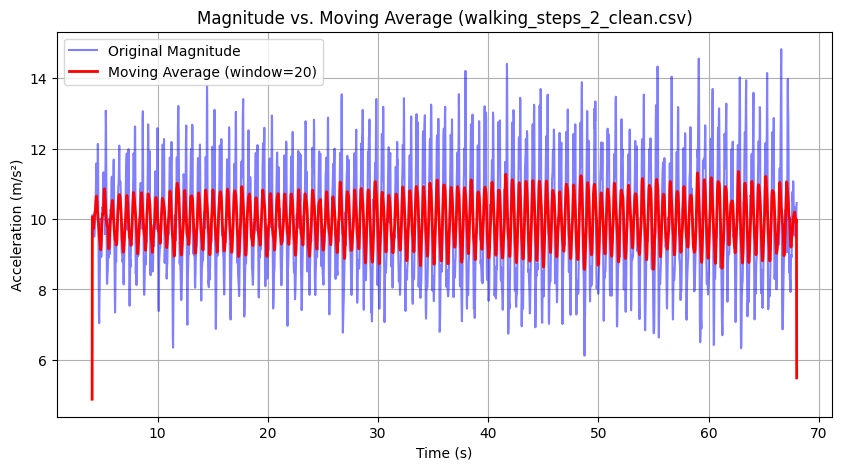

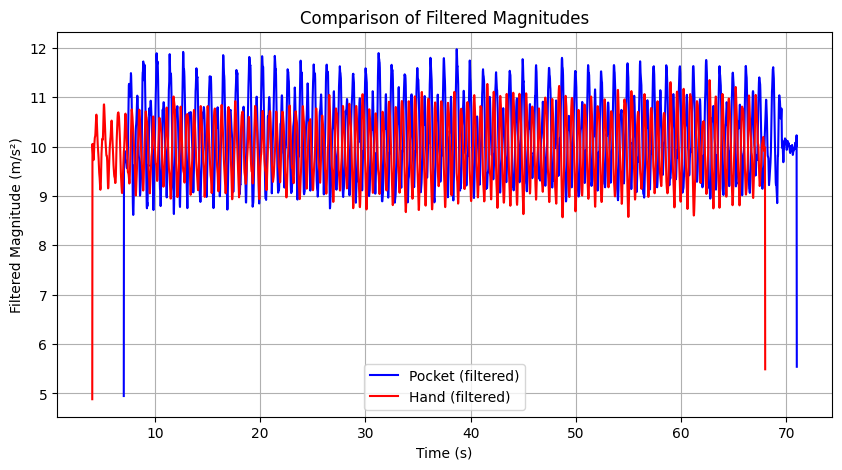

In [28]:
def plot_moving_average(times, magnitudes, filename, window_size=20):
    # Apply moving average filter
    filtered_mag = moving_average(magnitudes, window_size)

    # Create the plots
    plt.figure(figsize=(10, 5))
    plt.plot(times, magnitudes, 'b-', alpha=0.5, label='Original Magnitude')
    plt.plot(times, filtered_mag, 'r-', linewidth=2, label=f'Moving Average (window={window_size})')
    plt.title(f'Magnitude vs. Moving Average ({filename})')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return filtered_mag

# Apply to both datasets
window_size = 20  # We can experiment with different window sizes
filtered_mag1 = plot_moving_average(times1, mag1, "walking_steps_1_clean.csv", window_size)
filtered_mag2 = plot_moving_average(times2, mag2, "walking_steps_2_clean.csv", window_size)

# Compare both filtered magnitudes
plt.figure(figsize=(10, 5))
plt.plot(times1, filtered_mag1, 'b-', label='Pocket (filtered)')
plt.plot(times2, filtered_mag2, 'r-', label='Hand (filtered)')
plt.title('Comparison of Filtered Magnitudes')
plt.xlabel('Time (s)')
plt.ylabel('Filtered Magnitude (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

Accelerometer data graph


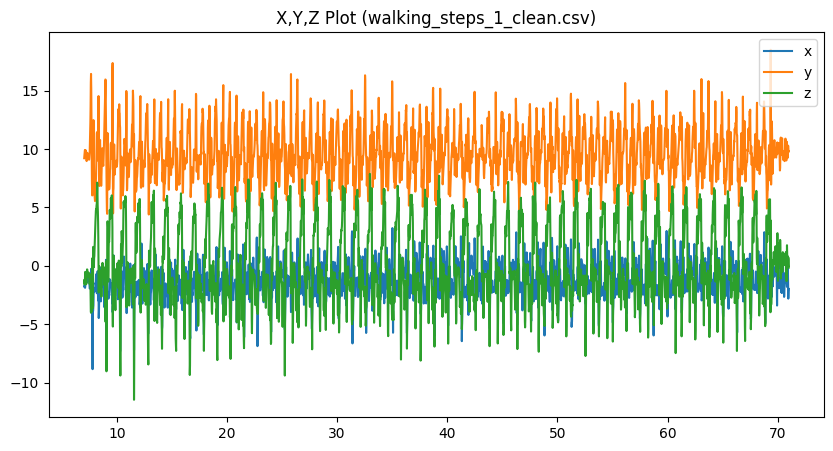

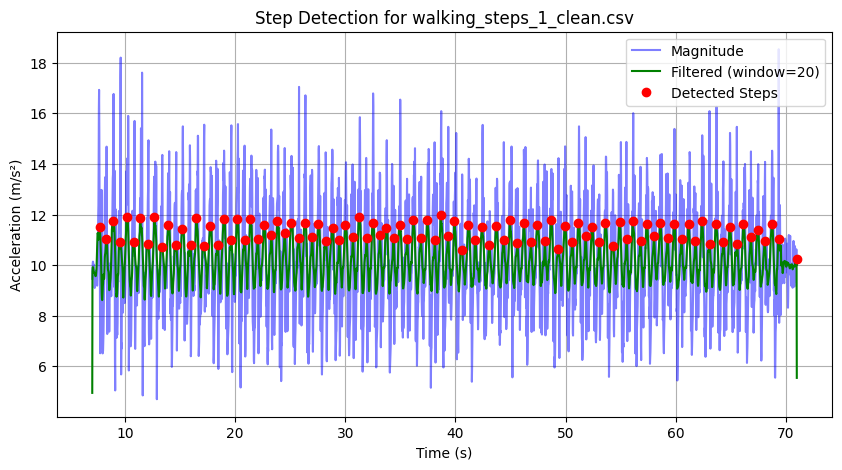

Number of steps counted are : 101
Accelerometer data graph


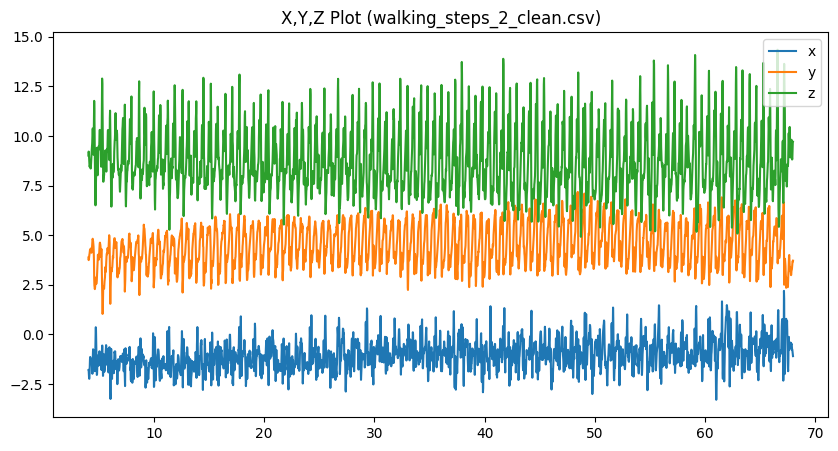

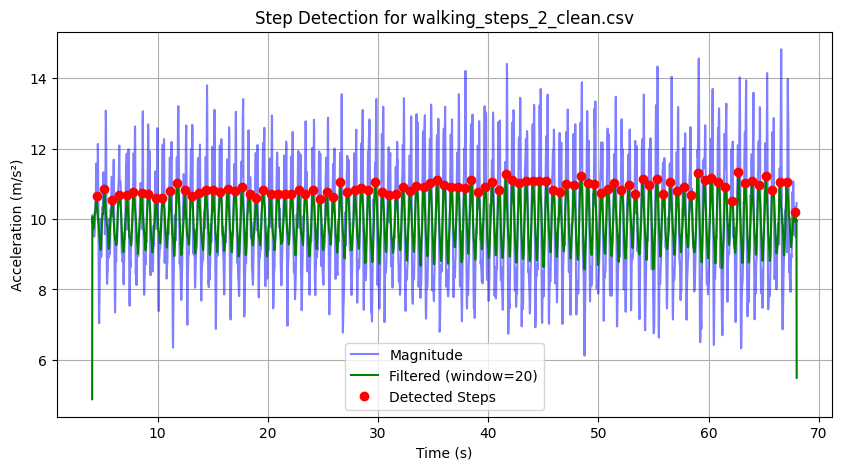

Number of steps counted are : 101


In [29]:
# this is task3.py
import numpy as np
import matplotlib.pyplot as plt
import parser_data
from scipy.signal import find_peaks


def count_steps(data, file_num):
    filename = f"walking_steps_{file_num}_clean.csv"

    print("Accelerometer data graph")
    plot_data(data, filename)
    # num_steps = 0
    '''
    ADD YOUR CODE HERE. This function counts the number of steps in data and returns the number of steps
    '''

    # Calculate magnitude
    magnitudes = vector_magnitude(data)
    times = [row[0] for row in data]

    # Apply moving average with optimal window size
    window_size = 20  # This can be adjusted
    filtered_mag = moving_average(magnitudes, window_size)

    # Find peaks (local maxima) in the filtered data
    # Adjust these parameters based on your specific data
    peak_height = np.mean(filtered_mag)  # Set minimum peak height around the mean
    peak_distance = 20  # Minimum number of samples between peaks (can be adjusted)

    # Find peaks in the filtered magnitude
    peaks, _ = find_peaks(filtered_mag, height=peak_height, distance=peak_distance)

    # Plot the magnitude, filtered magnitude, and detected peaks
    plt.figure(figsize=[10, 5])
    plt.plot(times, magnitudes, 'b-', alpha=0.5, label='Magnitude')
    plt.plot(times, filtered_mag, 'g-', label=f'Filtered (window={window_size})')
    plt.plot([times[p] for p in peaks], [filtered_mag[p] for p in peaks], 'ro', label='Detected Steps')
    plt.title(f'Step Detection for {filename}')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.legend()
    plt.grid(True)
    plt.show()

    num_steps = len(peaks)
    return num_steps



def main():
    # Get data
    for i in [1,2]:
        file_name = f"walking_steps_{i}_clean.csv"
        data = parser_data.get_data(file_name)
        number_of_steps = count_steps(data, i)
        print("Number of steps counted are : {0:d}".format(number_of_steps))

if __name__== "__main__":
    main()



<span style="color:blue; font-size:2em;"> **TASK 4** </span>

### INSTRUCTIONS
**In your report** <br>
a. **[10 points]** Explain your algorithm for segmentation, with rationale.  <br>
b. **[5 points]** Plot of pre-segmented data.  Plot segmented data for climbing and walking. Make sure the way you plot (colors/ boxes/lines) easily differentiates the two. <br>
c. **[5 points]** What was the difference in the step counting method from task 3? <br>
d. **[5 points]** How many steps of stairs did you count? Plot labeled data for climbed steps. <br>
e. **[5 points]** Reflect on this exercise and compare it with what you learned in class. (hint: bulling’s activity recognition chain) <br>


**Code and Data files** <br>
In folder /data - Add climbing_steps.csv <br>
Task4.py - modify segment_climbing_walking, count_steps below <br>

**Note: Make sure you add/modify code below or your task 4 will not be graded.**

segment_climbing_walking


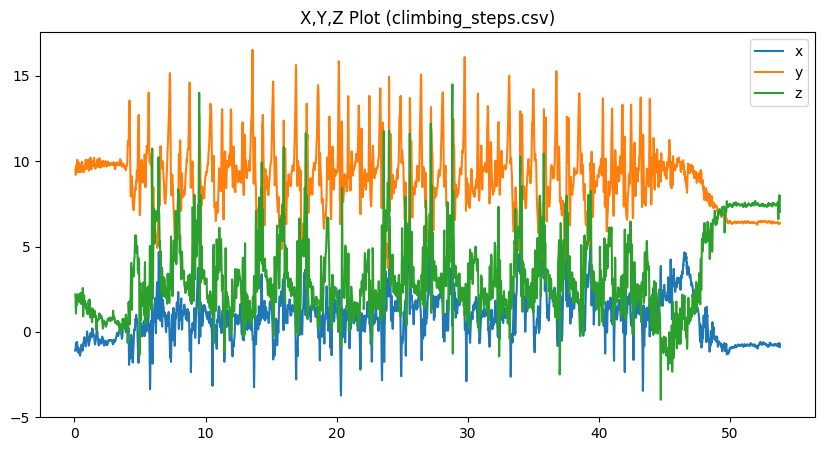

Successfully incorporated gyroscope data for segmentation
Number of samples classified as climbing: 2307
Total number of samples: 3223
Percentage classified as climbing: 71.58%


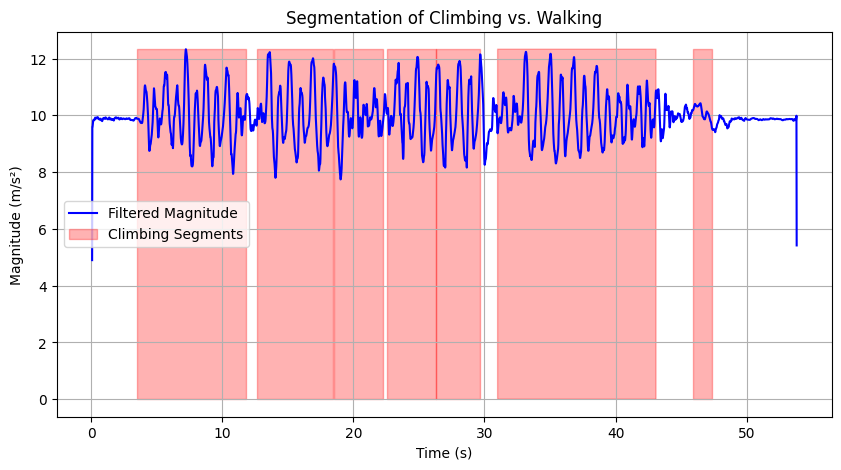

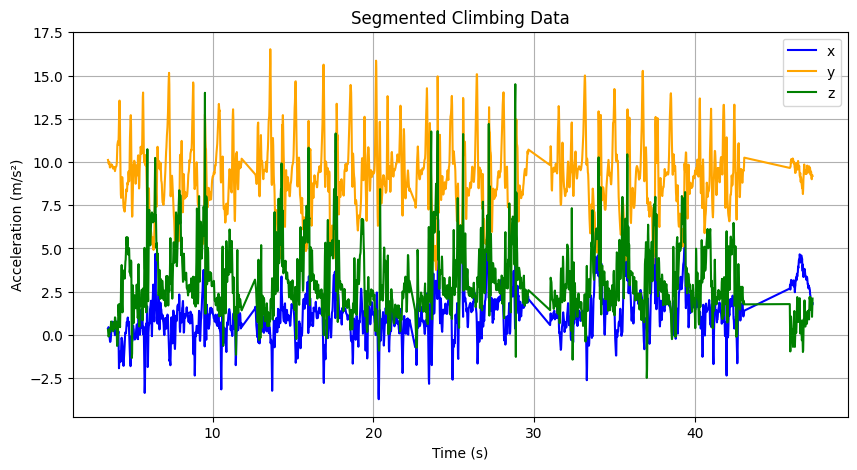

Counting steps in climbing segments...


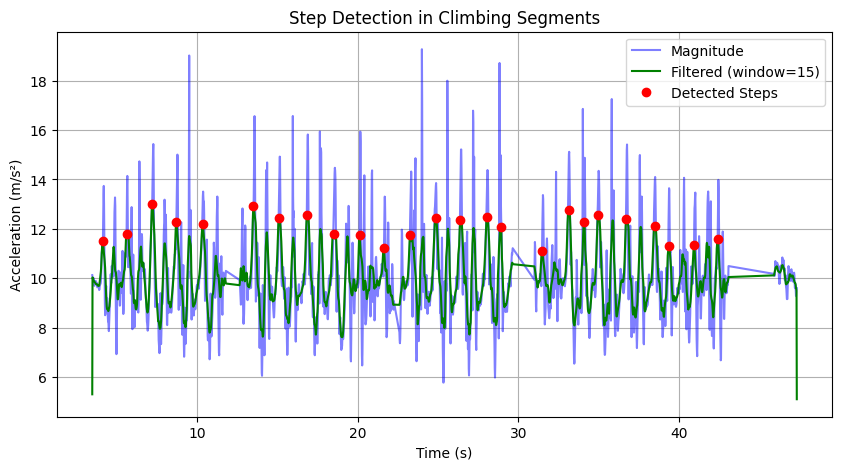

Detected 25 steps in climbing segments
Number of steps counted are :25


In [43]:
# this is task4.py

import parser_data
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def segment_climbing_walking(data):
    '''
    While collecting data on stairs there were times when you were also walking rather than climbing
    It is important to remove the parts from the data where you were walking in between the flight of stairs
    Write your own algorithm to find segments in data which corresponds to climbing only

    This functions returns
    List of tuples (x,y,z) which corresponds to climbing only.
    i.e. remove data points from the original data which corresponds to walking
    '''

    print ('segment_climbing_walking')
    plot_data(data, "climbing_steps.csv")

    # Extract time and acceleration data
    times = [row[0] for row in data]

    # Calculate magnitude of acceleration
    magnitudes = vector_magnitude(data)

    # Apply moving average to smooth the signal
    window_size = 20
    filtered_mag = moving_average(magnitudes, window_size)

    # Calculate variance in z-axis over sliding windows
    window_size_var = 50  # Larger window for variance calculation
    z_values = [row[3] for row in data]
    z_variance = []

    for i in range(len(z_values)):
        start_idx = max(0, i - window_size_var//2)
        end_idx = min(len(z_values), i + window_size_var//2)
        window_data = z_values[start_idx:end_idx]
        z_variance.append(np.var(window_data))

    # Apply moving average to smooth the variance signal
    z_variance_smooth = moving_average(z_variance, window_size)



# Load and process gyroscope data
    try:
        from scipy.interpolate import interp1d

        gyro_data = parser_data.get_data("task4/Gyroscope.csv")
        gyro_times = [row[0] for row in gyro_data]

        # Calculate gyroscope magnitude
        gyro_mag = []
        for point in gyro_data:
            x, y, z = point[1], point[2], point[3]
            magnitude = np.sqrt(x**2 + y**2 + z**2)
            gyro_mag.append(magnitude)

        # Interpolate gyro magnitude to match accel timestamps
        gyro_interp = interp1d(gyro_times, gyro_mag, bounds_error=False, fill_value="extrapolate")

        # Get gyro magnitude at accelerometer timestamps
        aligned_gyro_mag = gyro_interp(times)

        # Apply moving average to smooth gyro data
        smoothed_gyro = moving_average(aligned_gyro_mag, window_size)

        # Calculate gyro variance
        gyro_variance = []
        for i in range(len(smoothed_gyro)):
            start_idx = max(0, i - window_size_var//2)
            end_idx = min(len(smoothed_gyro), i + window_size_var//2)
            window_data = smoothed_gyro[start_idx:end_idx]
            gyro_variance.append(np.var(window_data))

        # Smooth gyro variance
        gyro_variance_smooth = moving_average(gyro_variance, window_size)

        # Set threshold for gyro variance
        gyro_threshold = np.mean(gyro_variance_smooth) * 1.5

        # Combine accelerometer and gyroscope information
        # Higher z-axis variance OR higher gyro variance indicates climbing/turning
        acc_threshold = np.mean(z_variance_smooth) * 1.2
        is_climbing_accel = [var > acc_threshold for var in z_variance_smooth]
        is_climbing_gyro = [var > gyro_threshold for var in gyro_variance_smooth]

        # Combine the two indicators
        is_climbing = [a or g for a, g in zip(is_climbing_accel, is_climbing_gyro)]

        print("Successfully incorporated gyroscope data for segmentation")

    except Exception as e:
        print(f"Error processing gyroscope data: {e}")
        print("Continuing with accelerometer-only approach")
        variance_threshold = np.mean(z_variance_smooth) * 1.2
        is_climbing = [var > variance_threshold for var in z_variance_smooth]




    # print(f"Number of samples classified as climbing: {sum(is_climbing)}")
    # print(f"Total number of samples: {len(is_climbing)}")
    # print(f"Percentage classified as climbing: {sum(is_climbing)/len(is_climbing)*100:.2f}%")


    # Smoothing
    min_segment_length = 30
    min_ratio = 0.3

    is_climbing_smoothed = is_climbing.copy()

    # Apply smoothing
    for i in range(1, len(is_climbing) - min_segment_length):
        if sum(is_climbing[i:i+min_segment_length]) > min_segment_length * min_ratio:
            is_climbing_smoothed[i:i+min_segment_length] = [True] * min_segment_length

    # Replace the original with the smoothed version
    is_climbing = is_climbing_smoothed


    print(f"Number of samples classified as climbing: {sum(is_climbing)}")
    print(f"Total number of samples: {len(is_climbing)}")
    print(f"Percentage classified as climbing: {sum(is_climbing)/len(is_climbing)*100:.2f}%")


    # Extract climbing segments
    climbing_data = []

    for i in range(len(data)):
        if is_climbing[i]:
            climbing_data.append(data[i])

    # Plot the segmentation results
    plt.figure(figsize=(10, 5))

    # Plot 1: Filtered magnitude with segmentation
    plt.plot(times, filtered_mag, 'b-', label='Filtered Magnitude')
    plt.fill_between(times, 0, max(filtered_mag), where=is_climbing,
                    color='red', alpha=0.3, label='Climbing Segments')
    plt.title('Segmentation of Climbing vs. Walking')
    plt.ylabel('Magnitude (m/s²)')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.grid(True)
    plt.show()  # Show the first plot

    # Plot 2: Segmented climbing data in a separate plot
    if climbing_data:
        # Create a new figure for the climbing data
        plt.figure(figsize=(10, 5))
        plt.title('Segmented Climbing Data')

        # Extract times and accelerations from climbing data
        climbing_times = [row[0] for row in climbing_data]
        climbing_x = [row[1] for row in climbing_data]
        climbing_y = [row[2] for row in climbing_data]
        climbing_z = [row[3] for row in climbing_data]

        # Plot X, Y, Z axes
        plt.plot(climbing_times, climbing_x, 'b-', label='x')
        plt.plot(climbing_times, climbing_y, 'orange', label='y')
        plt.plot(climbing_times, climbing_z, 'g-', label='z')
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.legend()
        plt.grid(True)
        plt.show()

    return climbing_data


def count_steps(data):
    print('Counting steps in climbing segments...')

    # Calculate magnitude of acceleration for the climbing segments
    magnitudes = vector_magnitude(data)
    times = [row[0] for row in data]

    # Apply moving average filter to smooth the data
    window_size = 15  # Slightly smaller window for stair steps
    filtered_mag = moving_average(magnitudes, window_size)

    # Find peaks (local maxima) in the filtered data

    # Calculate statistics for adaptive thresholding
    mean_mag = np.mean(filtered_mag)
    std_mag = np.std(filtered_mag)

    # Set peak parameters
    # Further refinements for step counting
    peak_height = mean_mag + 0.5 * std_mag  # Even higher threshold
    peak_distance = 53  # Greater minimum distance

    # Find peaks in the filtered magnitude
    peaks, _ = find_peaks(filtered_mag, height=peak_height, distance=peak_distance)

    # Plot the detection results
    plt.figure(figsize=(10, 5))
    plt.plot(times, magnitudes, 'b-', alpha=0.5, label='Magnitude')
    plt.plot(times, filtered_mag, 'g-', label=f'Filtered (window={window_size})')
    plt.plot([times[p] for p in peaks], [filtered_mag[p] for p in peaks], 'ro', label='Detected Steps')
    plt.title('Step Detection in Climbing Segments')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.legend()
    plt.grid(True)
    plt.show()

    num_steps = len(peaks)
    print(f"Detected {num_steps} steps in climbing segments")

    return num_steps


def main():
    # Get data
    file_name = "climbing_steps.csv"  # Change this to new data file name
    data = parser_data.get_data("task4/" + file_name)


    segmented_data = segment_climbing_walking(data)
    number_of_steps = count_steps(segmented_data)
    print ("Number of steps counted are :{0:d}".format(number_of_steps))


if __name__== "__main__":
    main()


<span style="color:blue; font-size:2em;"> **BONUS: TASK 5** </span>

### INSTRUCTIONS
**In your report** <br>
**[5 points]** Match the dataset to the TA! Write the name of the dataset as provided to you next to the TA’s name. <br>

**[5 points]** Explain your process and methods - how did you go about solving this problem? ATTACH your source-code Python file (task5.py).


**Code and Data files** <br>
In folder /data - Download and unzip the data from Canvas <br>
Task5.py - Modify source-code task5.py below.

**Note: Make sure you add/modify code below or your task 5 will not be graded.**

In [ ]:
# this is task5.py
"""
Task 5
Write the code for your task 5 in this file. You can use any method
you want. You can consider using the Bulling work flow. If you want,
you can use machine learning to solve the problem. Scikit learn is a
good python library for machine learning. You can also use the gui
interface of weka. If you do that, write your feature extraction
in this python file and describe how you used the weka gui to build the model.
"""
#your code here:
raise NotImplementedError